# CAMELS-GB_v2

This dataset provides catchment boundaries, hydro-meteorological timeseries and landscape attributes for 671 catchments across Great Britain.

Includes:
- River flows, river levels, groundwater levels, precipitation, potential evapotranspiration and temperature time series
- Daily hydro-meteorological timeseries from 1970 to 2022 (streamflow, PET, rainfall, temperature).
- Hourly hydro-meteorological timeseries from 1990 to 2022 (rainfall, riverflow)
- Catchment characteristics: land cover, hydrometry, human influences, location, topography, climate, hydrology, soils and hydrogeology
- Hydrologic signatures: quantitative, statistical, or dynamical metrics which charac-terise a catchment’s physical behaviour
    
It is described in detailed at: https://essd.copernicus.org/preprints/essd-2025-608/

## Load the attribute data
Explain usage of Pandas? Is that necessary?  
Might we actually need to load the data from a remote location? For now, load from the hydro4 server

In [8]:
import os
home_dir = "/scratch/hydro4/shared_data/uk_catchment_data/camels_gb_v2/"
import pandas as pd

In [9]:
topography = pd.read_csv(home_dir + "Catchment_Attributes/CAMELS_GB_v2_topographic_attributes.csv")
hydrologic_attributes = pd.read_csv(home_dir + "Catchment_Attributes/CAMELS_GB_v2_hydrologic_attributes.csv")
climatic_attributes = pd.read_csv(home_dir + "Catchment_Attributes/CAMELS_GB_v2_climatic_attributes.csv")

## Load the catchment data
Explain usage of geopandas?

In [10]:
import geopandas as gpd
# nrfa = gpd.read_file("/scratch/hydro4/shared_data/uk_catchment_data/shapefile_boundaries/NRFACatchmentsAll-2024.shp")
# nrfa.plot(color = 'None', linewidth= 1)

## Understanding where the data covers

We can have a look at which variables are present using the head() method which returns the first 5 rows of the DataFrame.

This shows us, as well as variables describing the catchment topography, the topography dataframe also contains the latitude and longitude of each gauge (where measurements for each catchment are made).

In [5]:
topography.head()

,gauge_id,gauge_name,gauge_lat,gauge_lon,gauge_easting,gauge_northing,gauge_elev,area,dpsbar,elev_mean,elev_min,elev_10,elev_50,elev_90,elev_max
0,10002,Ugie at Inverugie,57.53,-1.83,410113,848516,8.5,325.72,42.3,87,9.5,38.6,84.1,140.1,233.7
1,10003,Ythan at Ellon,57.36,-2.09,394684,830370,3.8,532.29,55.1,108,3.5,54.1,106.1,160.8,380.4
2,1001,Wick at Tarroul,58.48,-3.27,326202,954915,13.0,158.18,29.9,80,12.9,30.6,78.8,135.2,241.4
3,101002,Medina at Shide,50.69,-1.29,450359,88113,10.4,30.61,80.0,60,9.4,26.8,56.8,98.0,193.2
4,101005,Eastern Yar at Budbridge,50.65,-1.25,453120,83520,17.2,24.31,87.0,92,17.2,32.9,84.0,157.2,234.6


## Mapping gauge locations

We can use this information to plot a map showing the gauge locations, this requires the following steps:

- 1️⃣ Convert the tabular latitude–longitude data into a spatial object. 

This uses the Point() function from the shapely library to turn coordinate pairs into spatial point objects.

- 2️⃣ Convert the DataFrame to a GeoDataFrame

This uses the geopandas library. A GeoDataFrame looks like a normal pandas dataframe but has a special geometry column which stores the location as a georeferenced object with a coordinate reference system (crs). 

In [11]:
from shapely.geometry import Point

In [12]:
# Get just the gauge location information
gauge_locs = topography[['gauge_id', 'gauge_name', 'gauge_lat', 'gauge_lon']]
# Construct the geometry from the latitude and longitude using Shapely
geometry = [Point(xy) for xy in zip(topography.gauge_lon, topography.gauge_lat)]
# Create the geodataframe
# gauge_locs = topography.drop(['gauge_lon', 'gauge_lat'], axis=1)
gauge_locs_gdf = gpd.GeoDataFrame(gauge_locs, crs="EPSG:4326", geometry=geometry)
gauge_locs_gdf.head()

,gauge_id,gauge_name,gauge_lat,gauge_lon,geometry
0,10002,Ugie at Inverugie,57.53,-1.83,POINT (-1.83 57.53)
1,10003,Ythan at Ellon,57.36,-2.09,POINT (-2.09 57.36)
2,1001,Wick at Tarroul,58.48,-3.27,POINT (-3.27 58.48)
3,101002,Medina at Shide,50.69,-1.29,POINT (-1.29 50.69)
4,101005,Eastern Yar at Budbridge,50.65,-1.25,POINT (-1.25 50.65)


Then, Geopandas allows us to easily plot this information on a map, allowing us to see the gauge locations:

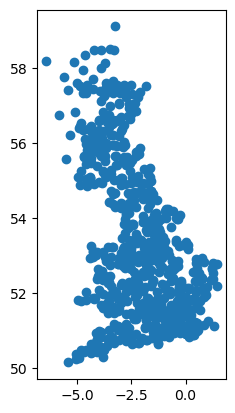

In [13]:
gauge_locs_gdf.plot();

In this dataset, the gauge density is so high that we can almost see the outline of the UK. To better inspect their spatial distribution, we can plot the gauges on a basemap.

Most web map tiles (e.g., those from CartoDB or OpenStreetMap) use the EPSG:3857 (Web Mercator) projection, and therefore we need to reproject the gauge data to this crs so that the gauges and the basemap align correctly.

In [14]:
gauge_locs_3857 = gauge_locs_gdf.to_crs(epsg=3857)
# nrfa_3857 = nrfa.to_crs(epsg=3857)

In order to plot both the gauge points and the basemap on the same canvas, here we first create a matplotlib figure and axes (fig, ax), before adding each of the two layers to the axis.

We add the basemap using the contextily package (expand?)

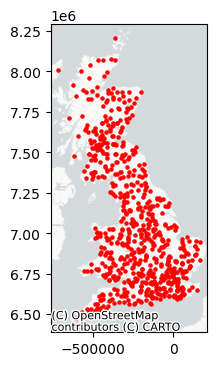

In [10]:
import matplotlib.pyplot as plt
import contextily as ctx

fig,ax=plt.subplots(figsize=(4,4))
gauge_locs_3857.plot(ax=ax, markersize=5, color="red")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
# nrfa_3857.plot(ax=ax, color = 'None', linewidth= 0.5)

Add rivers data? (not sure if this is really helpful)  
Open Source rivers data can be downloaded from here: https://osdatahub.os.uk/data/downloads/open/OpenRivers?_gl=1*1kmba3d*_gcl_au*MTM3MDczMjU0My4xNzcxMzI3MjA1*_ga*OTQ0Njc5NTY2LjE3NzEzMjcxOTY.*_ga_59ZBN7DVBG*czE3NzEzMjcxOTUkbzEkZzEkdDE3NzEzMjcyMDUkajUwJGwwJGgw

In [28]:
rivers = gpd.read_file("../Data/oprvrs_essh_gb/WatercourseLink.shp")
rivers_long = rivers[rivers['length'] > 1000]  # or some other attribute
rivers_simple = rivers_long.to_crs(epsg=4326).copy()
rivers_simple['geometry'] = rivers_simple['geometry'].simplify(tolerance=0.01, preserve_topology=True)

In [39]:
rivers_simple_3857= rivers_simple.to_crs(epsg=3857)

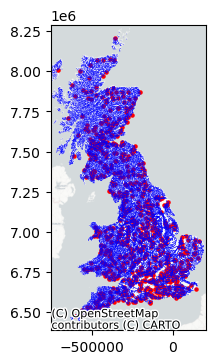

In [38]:
fig,ax=plt.subplots(figsize=(2,4))
gauge_locs_3857.plot(ax=ax, markersize=5, color="red")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
rivers_simple_3857.plot(ax=ax, color = 'blue', linewidth= 0.5);

Interactive plotting option?

In [33]:
# import folium
# from branca.element import Figure

# fig = Figure(width=400, height=400)

# # Make sure we use WGS84 (EPSG:4326)
# gdf = gauge_locs_gdf.to_crs(epsg=4326)

# # Create base map centred on mean location
# m = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()],zoom_start=5,tiles="CartoDB positron")
# fig.add_child(m)

# # Add gauge locations
# for _, row in gdf.iterrows():
#     folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=1, color="red",fill=True,fill_opacity=0.8).add_to(m)

# # Add catchment boundaries (simplify the catchments to reduce computation of plotting)
# # nrfa_simple = nrfa.to_crs(epsg=4326).copy()
# # nrfa_simple['geometry'] = nrfa_simple['geometry'].simplify(tolerance=0.01, preserve_topology=True)
# # folium.GeoJson(nrfa_simple,style_function=lambda x: {'fillColor': 'transparent','color': 'black','weight': 0.5 }).add_to(m)

# folium.GeoJson(rivers_long, style_function=lambda x: {'color': 'blue', 'weight': 1.5, 'opacity': 0.7}).add_to(m)

# # Display the map    
# m